In [8]:
import math
import yaml
import librosa
import torch
import torch.nn as nn
from os import path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from effortless_config import Config
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from core import get_scheduler, multiscale_fft, safe_log, mean_std_loudness

In [9]:
from models import DDSP_signal_only, DDSP_with_features
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

ddsp_model = DDSP_with_features(**config["model"]).to(device)

Using device: cuda:0


In [10]:
# from datasets.dataset_signal import Dataset

# dataset = Dataset(config)
# batch_size = config["hyperparams"]["batch_size"]
# dataloader = torch.utils.data.DataLoader(dataset,
#                                         batch_size,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         )

# print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader)).size())

In [11]:
from datasets.dataset_w_embedding import Dataset, get_files
from effortless_config import Config
import yaml
import torch

#get_files("config.yaml")

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

out_dir = config["preprocess"]["out_dir"]

dataset = Dataset(out_dir)
batch_size = config["hyperparams"]["batch_size"]
dataloader_train = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        True,
                                        drop_last=True,
                                        )

print("Size of dataset:", len(dataset), "\nSize of signal batch:", next(iter(dataloader_train))['signals'].size(), "\nSize of pitch batch:", next(iter(dataloader_train))['pitches'].size(), "\nSize of loudness batch:", next(iter(dataloader_train))['loudness'].size(), "\nSize of embedding batch:", next(iter(dataloader_train))['embeddings'].size())

Size of dataset: 217 
Size of signal batch: torch.Size([16, 64000]) 
Size of pitch batch: torch.Size([16, 256]) 
Size of loudness batch: torch.Size([16, 256]) 
Size of embedding batch: torch.Size([16, 256])


In [12]:
class args(Config):
    CONFIG = "config.yaml"
    NAME = "debug/male_speech"
    ROOT = "runs"
    STEPS = 500000
    START_LR = 1e-3
    STOP_LR = 1e-4
    DECAY_OVER = 400000

mean_loudness, std_loudness = mean_std_loudness(dataloader_train)
config["data"]["mean_loudness"] = mean_loudness
config["data"]["std_loudness"] = std_loudness

writer = SummaryWriter(path.join(args.ROOT, args.NAME), flush_secs=20)

with open(path.join(args.ROOT, args.NAME, "config.yaml"), "w") as out_config:
    yaml.safe_dump(config, out_config)

opt = torch.optim.Adam(ddsp_model.parameters(), lr=args.START_LR)

schedule = get_scheduler(
    len(dataloader_train),
    args.START_LR,
    args.STOP_LR,
    args.DECAY_OVER,
)

best_loss = float("inf")
mean_loss = 0
n_element = 0
step = 0
epochs = int(np.ceil(args.STEPS / len(dataloader_train)))

In [13]:
# losses = []

# def train(model, loader, optimizer):
#     model.train()
#     device = next(model.parameters()).device
#     total_loss = 0

#     for batch in loader:
#         batch = batch.to(device)
#         y = ddsp_model(batch).squeeze(-1)
                
#         ori_stft = multiscale_fft(
#             batch,
#             config["train"]["scales"],
#             config["train"]["overlap"],
#         )
#         rec_stft = multiscale_fft(
#             y,
#             config["train"]["scales"],
#             config["train"]["overlap"],
#         )

#         loss = 0
#         for s_x, s_y in zip(ori_stft, rec_stft):
#             lin_loss = (s_x - s_y).abs().mean()
#             log_loss = (safe_log(s_x) - safe_log(s_y)).abs().mean()
#             loss = loss + lin_loss + log_loss

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     total_loss /= len(loader)
#     losses.append(total_loss)
    
#     return total_loss

# for e in tqdm(range(epochs)):
#     loss = train(ddsp_model, dataloader, opt)
#     print("Epoch {} -- Loss {:3E}".format(e, loss))

In [14]:
import soundfile as sf

losses = []

for e in tqdm(range(epochs)):
    total_loss = 0
    for batch in dataloader_train:
        s = batch['signals'].to(device)
        p = batch['pitches'].unsqueeze(-1).to(device)
        l = batch['loudness'].unsqueeze(-1).to(device)
        em = batch['embeddings'].unsqueeze(-1).to(device)

        l = (l - mean_loudness) / std_loudness

        y = ddsp_model(s, p, l, em).squeeze(-1)

        ori_stft = multiscale_fft(
            s,
            config["train"]["scales"],
            config["train"]["overlap"],
        )
        rec_stft = multiscale_fft(
            y,
            config["train"]["scales"],
            config["train"]["overlap"],
        )

        loss = 0
        for s_x, s_y in zip(ori_stft, rec_stft):
            lin_loss = (s_x - s_y).abs().mean()
            log_loss = (safe_log(s_x) - safe_log(s_y)).abs().mean()
            loss = loss + lin_loss + log_loss

        opt.zero_grad()
        loss.backward()
        opt.step()

        writer.add_scalar("loss", loss.item(), step)

        step += 1

        n_element += 1
        mean_loss += (loss.item() - mean_loss) / n_element
        total_loss += loss.item()

    if not e % 10:
        writer.add_scalar("lr", schedule(e), e)
        writer.add_scalar("reverb_decay", ddsp_model.reverb.decay.item(), e)
        writer.add_scalar("reverb_wet", ddsp_model.reverb.wet.item(), e)
        # scheduler.step()
        if mean_loss < best_loss:
            best_loss = mean_loss
            torch.save(
                ddsp_model.state_dict(),
                path.join(args.ROOT, args.NAME, "state.pth"),
            )

        mean_loss = 0
        n_element = 0

        audio = torch.cat([s, y], -1).reshape(-1).detach().cpu().numpy()

        sf.write(
            path.join(args.ROOT, args.NAME, f"eval_{e:06d}.wav"),
            audio,
            config["preprocess"]["sample_rate"],
        )
    
    total_loss /= len(dataloader_train)
    losses.append(total_loss)


 14%|█▍        | 5368/38462 [1:22:07<8:26:21,  1.09it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'Epoch')

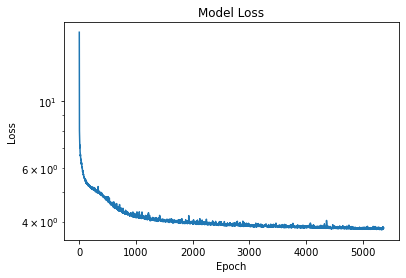

In [15]:
import matplotlib.pyplot as plt

plt.semilogy(losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [ ]:
from datasets.dataset_w_embedding import Dataset, get_files
import torch
import yaml
from effortless_config import Config

#get_files("config_test.yaml")

class args(Config):
    CONFIG = "config_test.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

out_dir = config["preprocess"]["out_dir"]

dataset = Dataset(out_dir)
batch_size = config["hyperparams"]["batch_size"]
dataloader_test = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        True,
                                        drop_last=True,
                                        )

print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader_test))['signals'].size(), "\nSize of sig batch:", next(iter(dataloader_test))['pitches'].size(), "\nSize of sig batch:", next(iter(dataloader_test))['loudness'].size(), "\nSize of sig batch:", next(iter(dataloader_test))['embeddings'].size())

Size of dataset: 81 
Size of sig batch: torch.Size([1, 64000]) 
Size of sig batch: torch.Size([1, 250]) 
Size of sig batch: torch.Size([1, 250])


In [ ]:
from models import DDSP_with_features
import soundfile as sf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class args(Config):
    CONFIG = "config_test.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

ddsp_model = DDSP_with_features(**config["model"]).to(device)

ddsp_model.load_state_dict(torch.load("runs/debug/male_speech/state.pth"))

class args(Config):
    CONFIG = "runs/debug/male_speech/config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

mean_loudness = config["data"]["mean_loudness"]
std_loudness = config["data"]["std_loudness"]

print(mean_loudness, std_loudness)

batch_train = next(iter(dataloader_train))
p_train = batch_train['pitches'].unsqueeze(-1).to(device)
median_pitch_train = torch.median(p_train)

batch = next(iter(dataloader_test))
s = batch['signals'].to(device)
p = batch['pitches'].unsqueeze(-1).to(device)
l = batch['loudness'].unsqueeze(-1).to(device)

l = (l - mean_loudness) / std_loudness
median_pitch_test = torch.median(p)
n = 12 * torch.log2(median_pitch_train/median_pitch_test)
p = torch.pow(torch.tensor(2), n/torch.tensor(12)) * p

y = ddsp_model(s, p, l).squeeze(-1)
y = torch.cat([s, y], -1).reshape(-1).detach().cpu().numpy()
sf.write("male_speech_test.wav", y, 16000)

Using device: cuda:0
-5.893357717073881 5.072404036155114
tensor(-9.7821, device='cuda:0')
